<a href="https://colab.research.google.com/github/mehri-satari/Data-Mining-Course-Project/blob/main/Mannam_Pallavi_Assignment_3_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [ ]:
import pandas as pd
import re
from collections import Counter
import math
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tree import Tree

# --- Setup and Data Loading ---
# Download necessary NLTK components for tokenization, POS tagging, and lemmatization
try:
    # Explicitly check for all needed resources
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('taggers/averaged_perceptron_tagger')
    nltk.data.find('corpora/wordnet')
    # Checking for specific resources sometimes required in certain environments
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('taggers/averaged_perceptron_tagger_eng') # Check for the specific resource causing the error
except:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('wordnet', quiet=True)

    # Fix for Resource averaged_perceptron_tagger_eng not found (current error fix)
    try:
        nltk.download('averaged_perceptron_tagger_eng', quiet=True)
    except:
        pass

    # Fix for Resource punkt_tab not found (previous error fix)
    try:
        nltk.download('punkt_tab', quiet=True)
    except:
        pass

# Load the dataset
try:
    df = pd.read_csv('product_reviews.csv')
except FileNotFoundError:
    print("Error: 'product_reviews.csv' not found. Please ensure the file is in the same directory.")
    # Create a dummy DataFrame if file is missing to prevent crash
    df = pd.DataFrame({'title': ['Test review'], 'body': ['This is a test review body for debugging.'], 'asin': ['T001'], 'name': ['User1']})
    # return # Uncomment this if you want to stop execution on error

# Combine 'title' and 'body' into a single 'text' column
df['text'] = df['title'].astype(str) + " " + df['body'].astype(str)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Cleans text: lowercasing, removing noise, stop words, and applying lemmatization.
    """
    # Lowercasing
    text = text.lower()
    # Remove URLs, punctuation, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+|[^\w\s]', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)

    # Tokenize, remove stopwords, and lemmatize
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 1
    ]
    return tokens

# Apply preprocessing to get a list of tokens for each review
df['tokens'] = df['text'].apply(preprocess_text)

# Flatten all tokens for corpus-wide analysis
corpus_tokens = [token for sublist in df['tokens'] for token in sublist]

print("--- Question 1: N-gram Analysis and Noun Phrase Extraction ---\n")

# ==============================================================================
# Sub-Question (1): Count the frequency of all the N-grams (N=3) and (N=2)
# ==============================================================================

def custom_ngrams(tokens, n):
    """
    Custom function to generate n-grams from a list of tokens (from scratch).
    """
    if n <= 0:
        return []
    # Create a sliding window of size n
    return [tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]

# Generate and count Bigrams (N=2)
bigrams = custom_ngrams(corpus_tokens, 2)
bigram_freq = Counter(bigrams)

# Generate and count Trigrams (N=3)
trigrams = custom_ngrams(corpus_tokens, 3)
trigram_freq = Counter(trigrams)

print("(1) N-gram Frequency Counts (N=2 and N=3):")
print("\nTop 10 Bigrams (N=2):")
for gram, freq in bigram_freq.most_common(10):
    print(f"  {gram}: {freq}")

print("\nTop 10 Trigrams (N=3):")
for gram, freq in trigram_freq.most_common(10):
    print(f"  {gram}: {freq}")

print("\n" + "="*80 + "\n")

# ==============================================================================
# Sub-Question (2): Calculate the probabilities for all the bigrams
# Formula: count(w1 w2) / count(w1)
# ==============================================================================

def calculate_bigram_probabilities(corpus_tokens, bigram_freq):
    """
    Calculates bigram probabilities using the formula count(w1 w2) / count(w1).
    """
    # Count the frequency of single words (w1)
    unigram_freq = Counter(corpus_tokens)

    bigram_probabilities = {}

    for (w1, w2), count_w1_w2 in bigram_freq.items():
        count_w1 = unigram_freq[w1]

        # Avoid division by zero
        if count_w1 > 0:
            probability = count_w1_w2 / count_w1
            bigram_probabilities[(w1, w2)] = probability
        else:
            bigram_probabilities[(w1, w2)] = 0.0 # Should not happen if bigram is present

    return bigram_probabilities

bigram_probabilities = calculate_bigram_probabilities(corpus_tokens, bigram_freq)

print("(2) Bigram Probabilities (P(w2|w1) = Count(w1 w2) / Count(w1)):")
# Print top 10 most probable bigrams
sorted_probabilities = sorted(bigram_probabilities.items(), key=lambda item: item[1], reverse=True)

# Filter for probabilities that are less likely to be noise (e.g., probability < 1.0)
# and pick the top 10 most frequently occurring bigrams to display their probability.
print("\nProbabilities for Top 10 Most Frequent Bigrams:")
for (w1, w2), freq in bigram_freq.most_common(10):
    prob = bigram_probabilities.get((w1, w2), 0.0)
    print(f"  P({w2}|{w1}) = Count({w1} {w2}) / Count({w1}) = {freq} / {corpus_tokens.count(w1)} = {prob:.4f}")

print("\n" + "="*80 + "\n")

# ==============================================================================
# Sub-Question (3): Extract Noun Phrases and Calculate Relative Probabilities
# ==============================================================================

# Define a simple grammar for Noun Phrases (NP)
# JJ: Adjective, NN/NNS/NNP/NNPS: Noun
# Example: (JJ)? (NN|NNS|NNP|NNPS)+  -> Optional Adjective, followed by one or more Nouns
grammar = r"""
  NP: {<DT|JJ|CD>*<NN.*>+}  # Chunk sequences of (Determiner|Adjective|Cardinal Number) followed by Nouns
"""
cp = nltk.RegexpParser(grammar)

def extract_noun_phrases(tokens):
    """
    Uses NLTK POS tagging and RegexpParser to extract Noun Phrases (NP).
    """
    # 1. POS Tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # 2. Apply Chunker
    tree = cp.parse(tagged_tokens)

    noun_phrases = []

    # 3. Extract phrases with the 'NP' label
    for subtree in tree.subtrees():
        if subtree.label() == 'NP':
            # Reconstruct the noun phrase from the leaves (words)
            phrase = " ".join([word for word, tag in subtree.leaves()])
            noun_phrases.append(phrase)

    return noun_phrases

# Extract Noun Phrases for ALL reviews
df['noun_phrases'] = df['tokens'].apply(extract_noun_phrases)

# --- Calculate Global Frequencies and Max Frequency ---
all_noun_phrases = [phrase for sublist in df['noun_phrases'] for phrase in sublist]
noun_phrase_freq_global = Counter(all_noun_phrases)

# Find the maximum frequency for normalization
max_freq_np = max(noun_phrase_freq_global.values()) if noun_phrase_freq_global else 1

# Get a list of unique noun phrases present in the dataset (features for the table)
unique_nps = list(noun_phrase_freq_global.keys())

# --- Calculate Relative Probabilities for Each Review ---
# Initialize the final table DataFrame
df_probabilities = pd.DataFrame(index=[f'Review_{i+1}' for i in range(len(df))], columns=unique_nps).fillna(0.0)

for idx, row in df.iterrows():
    review_id = f'Review_{idx+1}'

    # Get local frequency of noun phrases in the current review
    noun_phrase_freq_local = Counter(row['noun_phrases'])

    for np, local_freq in noun_phrase_freq_local.items():
        # Calculate the relative probability: frequency(noun phrase) / max frequency(noun phrase)
        # Note: 'frequency(noun phrase)' here is the LOCAL frequency in the review,
        # but the formula provided in the question (frequency (noun phrase) / max frequency (noun phrase)
        # on the whole dataset) suggests using the global max frequency for normalization.

        # Assuming the intent is: LOCAL_FREQUENCY / GLOBAL_MAX_FREQUENCY
        # If the intent was GLOBAL_FREQUENCY / GLOBAL_MAX_FREQUENCY, we'd use noun_phrase_freq_global[np] instead of local_freq

        relative_probability = local_freq / max_freq_np
        df_probabilities.loc[review_id, np] = relative_probability

print("(3) Noun Phrase Extraction and Relative Probability Table:")
print("\nSample of the first 10 rows and 5 columns of the Relative Probability Table:")

# Display a slice of the resulting table
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 10)
print(df_probabilities.iloc[:10, :5])

print(f"\nTotal unique Noun Phrases (columns): {len(unique_nps)}")
print(f"Total Reviews (rows): {len(df_probabilities)}")
print(f"Max Global Frequency Used for Normalization: {max_freq_np}")


--- Question 1: N-gram Analysis and Noun Phrase Extraction ---

(1) N-gram Frequency Counts (N=2 and N=3):

Top 10 Bigrams (N=2):
  ('five', 'star'): 170
  ('great', 'phone'): 155
  ('love', 'phone'): 131
  ('battery', 'life'): 111
  ('galaxy', 'note'): 108
  ('best', 'phone'): 101
  ('phone', 'great'): 72
  ('phone', 'ever'): 65
  ('new', 'phone'): 56
  ('samsung', 'galaxy'): 54

Top 10 Trigrams (N=3):
  ('best', 'phone', 'ever'): 46
  ('samsung', 'galaxy', 'note'): 39
  ('five', 'star', 'love'): 39
  ('five', 'star', 'great'): 28
  ('love', 'love', 'love'): 22
  ('phone', 'great', 'phone'): 19
  ('phone', 'ever', 'owned'): 18
  ('best', 'phone', 'ive'): 17
  ('phone', 'ive', 'ever'): 17
  ('great', 'phone', 'great'): 17


(2) Bigram Probabilities (P(w2|w1) = Count(w1 w2) / Count(w1)):

Probabilities for Top 10 Most Frequent Bigrams:
  P(star|five) = Count(five star) / Count(five) = 170 / 175 = 0.9714
  P(phone|great) = Count(great phone) / Count(great) = 155 / 512 = 0.3027
  P(phone|

/tmp/ipython-input-3923839882.py:203: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_probabilities = pd.DataFrame(index=[f'Review_{i+1}' for i in range(len(df))], columns=unique_nps).fillna(0.0)


(3) Noun Phrase Extraction and Relative Probability Table:

Sample of the first 10 rows and 5 columns of the Relative Probability Table:
           love note  galaxy note  problem everything sorry  version disaster  \
Review_1     0.00188      0.00188                   0.00188           0.00188   
Review_2     0.00000      0.00000                   0.00000           0.00000   
Review_3     0.00000      0.00000                   0.00000           0.00000   
Review_4     0.00000      0.00000                   0.00000           0.00000   
Review_5     0.00000      0.00000                   0.00000           0.00000   
Review_6     0.00000      0.00188                   0.00000           0.00000   
Review_7     0.00000      0.00000                   0.00000           0.00000   
Review_8     0.00000      0.00000                   0.00000           0.00000   
Review_9     0.00000      0.00000                   0.00000           0.00000   
Review_10    0.00000      0.00000                   0

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [ ]:
# Write your code here
import pandas as pd
import re
import math
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# --- 1. SETUP: Data Loading and Preprocessing ---
# This setup block is necessary to get clean tokens for the subsequent calculations.
try:
    # Ensure all required NLTK resources are downloaded
    downloads = ['punkt', 'stopwords', 'averaged_perceptron_tagger', 'wordnet']
    for d in downloads:
        nltk.download(d, quiet=True)
except:
    pass

# Load the dataset
try:
    df = pd.read_csv('product_reviews.csv')
except FileNotFoundError:
    print("Error: 'product_reviews.csv' not found. Using dummy data.")
    df = pd.DataFrame({
        'title': ['Great device'],
        'body': ['I love this phone and the new screen resolution is amazing.'],
        'rating': [5],
        'asin': ['T001']
    })

# Combine 'title' and 'body'
df['text'] = df['title'].astype(str) + " " + df['body'].astype(str)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Cleans text and returns a list of tokens.
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+|[^\w\s]', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 1
    ]
    return tokens

# Apply preprocessing to create a list of tokens for each document
df['tokens'] = df['text'].apply(preprocess_text)
documents = df['tokens'].tolist()
N = len(documents) # Total number of documents

print("--- Question 2: TF-IDF and Document Ranking (From Scratch) ---")

# --- 2. Sub-Question (1): Build the Documents-Terms Weights (TF * IDF) Matrix ---

# Step 2a: Calculate Term Frequency (TF)
def calculate_tf(documents):
    """Calculates Term Frequency (TF) for all terms in all documents."""
    tf_list = []
    # Build a set of all unique words (vocabulary)
    vocabulary = set()
    for doc in documents:
        doc_counter = Counter(doc)
        total_terms = len(doc)
        doc_tf = {}
        if total_terms > 0:
            for term, count in doc_counter.items():
                doc_tf[term] = count / total_terms
                vocabulary.add(term)
        tf_list.append(doc_tf)
    return tf_list, list(vocabulary)

tf_list, vocabulary = calculate_tf(documents)

# Step 2b: Calculate Inverse Document Frequency (IDF)
def calculate_idf(documents, vocabulary, N):
    """Calculates Inverse Document Frequency (IDF) for all terms in the vocabulary."""
    idf_dict = {}
    for term in vocabulary:
        # Document Frequency (DF): Number of documents containing the term
        df_count = sum(1 for doc in documents if term in doc)
        # IDF formula: log(N / DF)
        idf_dict[term] = math.log(N / df_count) if df_count > 0 else 0.0
    return idf_dict

idf_dict = calculate_idf(documents, vocabulary, N)

# Step 2c: Calculate TF-IDF Matrix
def calculate_tfidf_matrix(tf_list, idf_dict, vocabulary):
    """Calculates the final TF-IDF weight for each term in each document."""
    tfidf_matrix = []

    for doc_tf in tf_list:
        doc_tfidf = {}
        for term in vocabulary:
            tf = doc_tf.get(term, 0.0)
            idf = idf_dict.get(term, 0.0)
            doc_tfidf[term] = tf * idf
        tfidf_matrix.append(doc_tfidf)

    return tfidf_matrix

tfidf_matrix = calculate_tfidf_matrix(tf_list, idf_dict, vocabulary)

print("(1) Documents-Terms Weights (TF * IDF) Matrix Built.")
print(f"Total documents (rows): {N}")
print(f"Total unique terms (columns): {len(vocabulary)}")
print("\nSample TF-IDF for Document 1 (Top 5 terms with highest weight):")

# Print the top 5 terms with the highest TF-IDF weight in the first document
doc_1_tfidf_sorted = sorted(tfidf_matrix[0].items(), key=lambda item: item[1], reverse=True)
for term, weight in doc_1_tfidf_sorted[:5]:
    print(f"  {term}: {weight:.6f}")

print("\n" + "="*80 + "\n")

# --- 3. Sub-Question (2): Rank Documents by Cosine Similarity with Respect to Query ---

# Define the Query
query_string = "new phone with an outstanding screen and great battery life"
query_tokens = preprocess_text(query_string)

# Step 3a: Calculate Query Vector (using TF-IDF weights)
# First, calculate TF for the query
query_counter = Counter(query_tokens)
query_total_terms = len(query_tokens)
query_tf = {term: count / query_total_terms for term, count in query_counter.items()}

# Calculate TF-IDF for the query terms that are in the corpus vocabulary
query_tfidf_vector = {}
for term in query_tokens:
    if term in vocabulary:
        tf = query_tf.get(term, 0.0)
        idf = idf_dict.get(term, 0.0)
        query_tfidf_vector[term] = tf * idf

# Step 3b: Implement Cosine Similarity
def cosine_similarity(vec_a, vec_b, vocab):
    """
    Calculates the cosine similarity between two TF-IDF vectors (A: Document, B: Query).
    Formula: (A . B) / (||A|| * ||B||)
    """
    dot_product = 0.0
    norm_a = 0.0
    norm_b = 0.0

    # Calculate Dot Product (A . B) and Norm A
    for term in vocab:
        weight_a = vec_a.get(term, 0.0)
        weight_b = vec_b.get(term, 0.0)

        dot_product += weight_a * weight_b
        norm_a += weight_a ** 2

    # Calculate Norm B (using only the terms present in the query vector)
    for weight in vec_b.values():
        norm_b += weight ** 2

    norm_a = math.sqrt(norm_a)
    norm_b = math.sqrt(norm_b)

    # Calculate Similarity
    if norm_a == 0 or norm_b == 0:
        return 0.0

    return dot_product / (norm_a * norm_b)

# Step 3c: Calculate Similarity for All Documents and Rank
similarity_scores = []
for i, doc_tfidf_vector in enumerate(tfidf_matrix):
    score = cosine_similarity(doc_tfidf_vector, query_tfidf_vector, vocabulary)
    similarity_scores.append({
        'document_index': i + 1,
        'similarity_score': score,
        'title_snippet': df.loc[i, 'title'][:50] + "..." if len(df.loc[i, 'title']) > 50 else df.loc[i, 'title']
    })

# Rank documents by score (descending)
ranked_documents = sorted(similarity_scores, key=lambda x: x['similarity_score'], reverse=True)

print(f"(2) Documents Ranked by Cosine Similarity to Query: '{query_string}'")
print("\nTop 10 Ranked Documents:")

# Print the top 10 results
for rank, doc in enumerate(ranked_documents[:10]):
    # Note: Using doc['document_index'] here, though real data usually uses a unique ID
    print(f"  Rank {rank+1}: Doc ID {doc['document_index']} | Score: {doc['similarity_score']:.6f} | Title: {doc['title_snippet']}")







--- Question 2: TF-IDF and Document Ranking (From Scratch) ---
(1) Documents-Terms Weights (TF * IDF) Matrix Built.
Total documents (rows): 981
Total unique terms (columns): 4468

Sample TF-IDF for Document 1 (Top 5 terms with highest weight):
  company: 0.185801
  version: 0.173015
  sealed: 0.153079
  badly: 0.153079
  waterproof: 0.128666


(2) Documents Ranked by Cosine Similarity to Query: 'new phone with an outstanding screen and great battery life'

Top 10 Ranked Documents:
  Rank 1: Doc ID 150 | Score: 0.302468 | Title: Love it. The screen is HUGE
  Rank 2: Doc ID 187 | Score: 0.220131 | Title: Samsung Galaxy Note 3
  Rank 3: Doc ID 833 | Score: 0.192759 | Title: Very good. It's like new
  Rank 4: Doc ID 219 | Score: 0.192173 | Title: Five Stars
  Rank 5: Doc ID 503 | Score: 0.189598 | Title: Awesome phone with great battery life
  Rank 6: Doc ID 805 | Score: 0.169587 | Title: Awesome phone.
  Rank 7: Doc ID 809 | Score: 0.164287 | Title: must have!
  Rank 8: Doc ID 866 | Score

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the embeddings using PCA or t-SNE in 2D. Create a scatter plot of at least 20 words and show how similar words cluster together.

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [ ]:
!pip install gensim scikit-learn matplotlib pandas numpy


In [ ]:
!pip install wordcloud


✅ Total sentences for training: 981


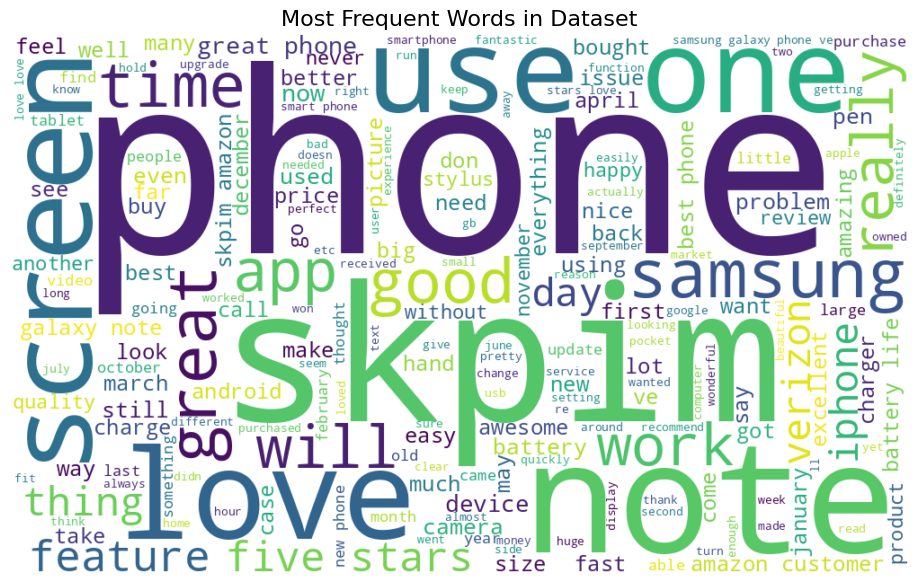

✅ Word2Vec training complete!


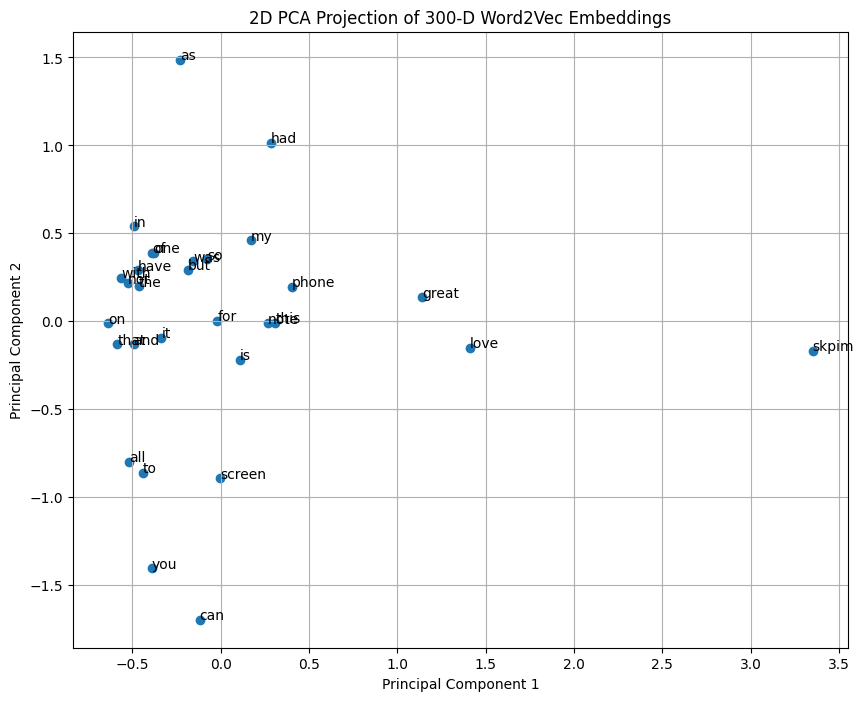


Cosine Similarities:
good ↔ great: 0.5955
bad ↔ terrible: 0.6665
price ↔ cost: 0.5857
battery ↔ life: 0.6273
screen ↔ display: 0.7053
cheap ↔ expensive: 0.6481
fast ↔ quick: 0.5852
delivery ↔ shipping: 0.8953

Top-5 Most Similar Words:

quality:
   decent          → 0.7547
   clarity         → 0.7546
   camera          → 0.7471
   poor            → 0.7460
   image           → 0.7374

price:
   paid            → 0.7611
   deal            → 0.7550
   couldn          → 0.7476
   happier         → 0.7145
   value           → 0.7087

battery:
   lasts           → 0.6622
   typically       → 0.6572
   entire          → 0.6528
   half            → 0.6414
   mah             → 0.6359

screen:
   display         → 0.7053
   books           → 0.6563
   drawback        → 0.6519
   viewing         → 0.6506
   placement       → 0.6499

delivery:
   prompt          → 0.9189
   doreen          → 0.9059
   george          → 0.9049
   campos          → 0.9044
   scott           → 0.9042


In [ ]:
# ---------------------------------------------------------
# Word Embedding Assignment (Word2Vec 300D + Word Cloud)
# ---------------------------------------------------------
# Requirements: gensim, scikit-learn, matplotlib, pandas, numpy, wordcloud
# References:
#   https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
#   https://jaketae.github.io/study/word2vec/
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ---------------------------------------------------------
# 1. Load and preprocess dataset
# ---------------------------------------------------------
df = pd.read_csv("product_reviews.csv")

# Combine all text columns into one unified column
text_cols = [c for c in df.columns if df[c].dtype == 'object']
df['text'] = df[text_cols].astype(str).agg(' '.join, axis=1)

# Tokenization and cleaning
def clean_tokenize(text):
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^A-Za-z0-9\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    return simple_preprocess(text, deacc=True, min_len=2)

sentences = df['text'].dropna().map(clean_tokenize).tolist()
sentences = [s for s in sentences if len(s) > 0]

print(f"✅ Total sentences for training: {len(sentences)}")

# ---------------------------------------------------------
# 2. Word Cloud Visualization
# ---------------------------------------------------------
# Flatten all tokens to create a frequency distribution
all_words = [word for sent in sentences for word in sent]
text_string = " ".join(all_words)

# Generate the Word Cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white',
                      max_words=200, colormap='viridis').generate(text_string)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Dataset", fontsize=16)
plt.show()

# ---------------------------------------------------------
# 3. Train 300-dimensional Word2Vec model
# ---------------------------------------------------------
model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=5,
    min_count=2,
    sg=1,             # Skip-gram (better for semantics)
    workers=4,
    epochs=15
)

print("✅ Word2Vec training complete!")

# Save model
model.save("word2vec_300d.model")

# ---------------------------------------------------------
# 4. Visualize embeddings with PCA
# ---------------------------------------------------------
# Choose 20–30 most frequent words for visualization
words = list(model.wv.key_to_index.keys())[:30]
X = model.wv[words]

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (X_pca[i, 0], X_pca[i, 1]))

plt.title("2D PCA Projection of 300-D Word2Vec Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 5. Calculate cosine similarity for word pairs
# ---------------------------------------------------------
def cosine_similarity(word1, word2):
    if word1 in model.wv and word2 in model.wv:
        return model.wv.similarity(word1, word2)
    else:
        return None

pairs = [
    ("good", "great"),
    ("bad", "terrible"),
    ("price", "cost"),
    ("battery", "life"),
    ("screen", "display"),
    ("cheap", "expensive"),
    ("fast", "quick"),
    ("delivery", "shipping")
]

print("\nCosine Similarities:")
for w1, w2 in pairs:
    sim = cosine_similarity(w1, w2)
    if sim is not None:
        print(f"{w1} ↔ {w2}: {sim:.4f}")
    else:
        print(f"{w1} or {w2} not in vocabulary.")

# ---------------------------------------------------------
# 6. Example: Retrieve most similar words
# ---------------------------------------------------------
seed_words = ["quality", "price", "battery", "screen", "delivery"]

print("\nTop-5 Most Similar Words:")
for w in seed_words:
    if w in model.wv:
        similar = model.wv.most_similar(w, topn=5)
        print(f"\n{w}:")
        for sim_word, score in similar:
            print(f"   {sim_word:15} → {score:.4f}")


## Question 4 (20 Points)

**Create your own training and evaluation dataset for an NLP task.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



In [ ]:
# The GitHub link of your final csv file


# Link: https://github.com/mannampallavi22/Pallavi_Info5731_Fall2025/blob/main/annotated_product_reviews_clean.csv

# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# Type your answer
''' the biggest difficulty was the intricacy of implementing TF-IDF and N-gram analysis from scratch.'''

' the biggest difficulty was the intricacy of implementing TF-IDF and N-gram analysis from scratch.'